<a href="https://colab.research.google.com/github/nfinan/MAMMAL/blob/main/NanoMine/CaseStudies/PredictTg/PredictTg_MPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl -U

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
print("Current working directory: {0}".format(os.getcwd()))

directory = "/content/drive/My Drive/Duke/Boran Shared/Final package/"
# directory = "/content/drive/My Drive/Duke/Boran Shared/"
# directory = "/content/drive/My Drive/Duke/"
os.chdir(directory)
print("Current working directory: {0}".format(os.getcwd()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content
Current working directory: /content/drive/.shortcut-targets-by-id/1jb1N-EgiU-q_1kgJrBTfBk5O62rWv8zq/Final package


In [ ]:
def iscolab():
    return get_ipython().__class__.__module__ == "google.colab._shell"

In [ ]:
# df = pd.read_excel('Used_dataset.xlsx')
# df.head()

# DTg = df[' deltaTg ']
# Vf = df[' VolFrac ']

In [ ]:
"""
Created on Thurs Feb 3 2022

@author: nicholasfinan
"""

from math import log
import pandas as pd
# from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
# import math
# from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
import seaborn as sns

#%% Data pretreatment
#Associates to each sample their surface energy and eliminate the sample for which surface energy is not available
df = pd.read_excel('Used_dataset.xlsx')
df_nrj = pd.read_excel('SE_resultat.xlsx')



DTg = df[' deltaTg ']
Vf = df[' VolFrac ']
Matrix = df[' matrix ']
PST = df[' PST ']
Doi = df['doi']
Cluster_vf = df['Cluster vf']
Cluster_ws = df['Cluster ws']
Cluster = df['Cluster']
cpt_nrj = df_nrj['Component']
gamma_d = df_nrj['Dispersive surface energy']
gamma_p = df_nrj['Polar surface energy']
pol_type = df['Polymer type']
Process = df['Processing category']
Tgratio = df['Tg ratio']

Gamma_d_matrix = []
Gamma_p_matrix = []
Gamma_d_filler = []
Gamma_p_filler = []

dtg =[]
vf = []
matrix = []
pst = []
doi = []
cluster_vf = []
cluster_ws = []
cluster = []
process = []
tgratio = []
def find_gamma(mat, fil):
    g_d_m , g_d_f =0 , 0 
    for k , cpt in enumerate(cpt_nrj):
        if mat in cpt:
            g_d_m , g_p_m = gamma_d[k] , gamma_p[k]
        elif fil in cpt:
            g_d_f , g_p_f = gamma_d[k] , gamma_p[k]
    
    if g_d_m != 0 and g_d_f != 0:
        return g_d_m , g_p_m ,g_d_f , g_p_f
    else:
        return False
    
    

for k in range(Matrix.shape[0]):
    mat  , fil= Matrix[k] , PST[k]
    if str(mat) == 'nan':
        break
    
    G = find_gamma(mat , fil)
    if G is not False:
        Gamma_d_matrix.append(G[0])
        Gamma_p_matrix.append(G[1])
        Gamma_d_filler.append(G[2])
        Gamma_p_filler.append(G[3])
        dtg.append(DTg[k])
        vf.append(Vf[k])
        doi.append(Doi[k])
        matrix.append(mat)
        pst.append(fil)
        cluster_vf.append(Cluster_vf[k])
        cluster_ws.append(Cluster_ws[k])
        process.append(Process[k])
        cluster.append(Cluster[k])
        tgratio.append(Tgratio[k])
    else:
        print('no result', mat , fil)
    

Delta_tg = np.array(dtg)
Matrix = np.array(matrix)
PST = np.array(pst)    
Vf = np.array(vf)
Doi = np.array(doi)
Cluster_vf = np.array(cluster_vf)
Cluster_ws = np.array(cluster_ws)
Cluster = np.array(cluster)
Process = np.array(process)
Tgratio = np.array(tgratio)
Gamma_d_matrix = np.array(Gamma_d_matrix)
Gamma_p_matrix = np.array(Gamma_p_matrix)
Gamma_d_filler = np.array(Gamma_d_filler)
Gamma_p_filler = np.array(Gamma_p_filler)
    

#Calculation of the 3 surface energy parameters

Gamma_F = Gamma_d_filler + Gamma_p_filler
Gamma_P = Gamma_d_matrix + Gamma_p_matrix
Wpf = 2*((Gamma_d_filler*Gamma_d_matrix)**0.5 + (Gamma_p_filler*Gamma_p_matrix)**0.5)
Wff = 2*Gamma_F
Wpp = 2*Gamma_P


Wa = Wff + Wpp - 2*Wpf
Ws = Wpf / Wpp #altered
Ws_orig = Wpf - Wpp #unalteered
# Ws = Wpf - Wpp
Costheta = 2*Wpf/Wff -1
for k , c in enumerate(Costheta):
    if c>1:
        Costheta[k] = 1
        
# Data are saved in panda Dataframe
X = np.concatenate((Ws.reshape(-1,1), Ws_orig.reshape(-1,1), Wa.reshape(-1,1), Costheta.reshape(-1,1), Vf.reshape(-1,1), Delta_tg.reshape(-1,1), Gamma_p_matrix.reshape(-1,1), Gamma_p_filler.reshape(-1,1), Gamma_d_matrix.reshape(-1,1), Gamma_d_filler.reshape(-1,1)), axis=1)
# column = ['Ws', 'Wa', 'Costheta','Vf', 'Dtg' , 'Delta_G', 'Gamma_pf' , 'Gamma_p_m' , 'Gamma_p_f'  , 'Gamma_d_m' , 'Gamma_d_f']
# Note: add thermal data: component melting temp
column = ['Ws', 'Ws_orig', 'Wa', 'Costheta','Vf', 'Dtg' , 'Gamma_p_m' , 'Gamma_p_f'  , 'Gamma_d_m' , 'Gamma_d_f']
Data = pd.DataFrame(X , columns = column)
Data['matrix'] = pd.Series(Matrix)
Data['PST'] = pd.Series(PST)
Data['Doi'] = pd.Series(Doi)
Data['composition'] = Data[['matrix' , 'PST' , 'Doi']].apply(lambda row:row[0]+', '+row[1]+ ', '+row[2] ,axis=1)
Data['polymer type'] = pd.Series(pol_type)
Data['cluster vf'] = pd.Series(Cluster_vf).astype(str)
Data['cluster ws'] = pd.Series(Cluster_ws).astype(str)
Data['Process'] = pd.Series(Process)
Data['cluster'] = pd.Series(Cluster)
Data['Tg ratio'] = pd.Series(Tgratio)
def group(row):
    if row[0]=='bottom cluster' and row[1]=='upper cluster':
        return 'changed'
    if row[0]=='upper cluster' and row[1]=='upper cluster':
        return 'stayed'
    


#%% New parameter definition
        
Data = Data[Data['polymer type'] != 'thermoset']
# Data = Data[Data['Dtg']>0] ######----------------------------------------------IMORTANT REMOVAL OF NEGATIVE TG VALUES---------------------------------------
Data['move']= Data[['cluster ws' , 'cluster vf']].apply(group , axis=1)



#%% Dataset analysis
    
# nb_sample = Vf.shape[0]
# print(nb_sample)
# fig = px.histogram(x=Data['Ws'] , labels={'x' : 'Ws'})
# fig.write_html('X.html', auto_open=True)

# g = sns.PairGrid(Data[['Wa' , 'Ws' ]])
# g = g.map_diag(plt.hist)
# g = g.map_offdiag(plt.scatter)


#%% Regression functions 

def linear_regression(X , Y , ax=0  , plot=False):
    reglin = linear_model.LinearRegression()
    Xmin = X.min()
    Xmax = X.max()
    Ymax = Y.max()
    Ymin = Y.min()
    if type(X) == type(pd.Series([1])):
        X = X.to_numpy().reshape(-1,1)
    reglin.fit(X , Y)
    print("Coefficients: ",reglin.coef_,"\nIntercept:",reglin.intercept_,"\nCoefficent of determination",reglin.score(X ,Y))
    if plot:
        ax.text((Xmax+Xmin)/2, Ymin ,'R^2 = '+str(round(reglin.score(X ,Y),2) ), fontsize=8)
        Ypred = reglin.predict(X)
        ax.plot(X , Ypred , 'b' ,label='y ='+str(reglin.coef_) + 'x + '+ str(reglin.intercept_))
        ax.legend(fontsize=8)
    return reglin.coef_[0] , reglin.intercept_ , round(reglin.score(X ,Y),2)

def multilinear_reg (Data , column , Y):
    Y = Data[Y].apply(lambda x:np.log(abs(x)))
    X = Data[column].apply(lambda x:np.log(abs(x)))
    reglin = linear_model.LinearRegression()   
    reglin.fit(X , Y)
    print("Coefficients: ",reglin.coef_,"\nIntercept:",reglin.intercept_,"\nCoefficent of determination",reglin.score(X ,Y))
    # # perform permutation importance
    # results = permutation_importance(reglin, X, Y, scoring='neg_mean_squared_error',n_repeats=50)
    # # get importance
    # importance = results.importances_mean
    # # summarize feature importance
    # for i,v in enumerate(importance):
    #  	print('Feature: %0d, Score: %.5f' % (i,v))
    # # plot feature importance
    # plt.bar(column, importance)
    # plt.title('Permutation predictors importance')
    # plt.ylabel('Score')
    # plt.show()
    return reglin.coef_



#%% Draw Function

def draw(data , formula='X' , LinReg = True , title=None, clustering='cluster ws'):

    auto_open = not iscolab()

    xmin = data['X'].min()
    xmax = data['X'].max()
    
    def f(x , a , b):
        return a*x + b
    
    Xreg = np.array([xmin,xmax])
    
    a , b , R = linear_regression(data['X'], data['Dtg'] ,plot=False)
    
    Yreg = f(Xreg , a , b)
    
            
    fig = px.scatter(x=data['X'] , y=data['Dtg'] , color=data[clustering] , size=data['Vf'] , hover_name=data['composition'] ,title=title, labels={'x':formula ,'y':'Delta Tg' , 'color':clustering , 'symbol':clustering , 'size':'Volume fraction'})
    
    if LinReg:
        
        fig.add_trace(go.Scatter(x=Xreg, y=Yreg, mode='lines', name='Linear regression from data' , text='R= '+str(R)))
    
    fig.write_html(formula+"_"+clustering+'.html', auto_open=auto_open)




column = [ 'Ws', 'Vf']


#Data scaling
# index = list(Data.index.values)

# min_max_scaler = preprocessing.MinMaxScaler()
# scaled = min_max_scaler.fit_transform(Data[column]) 
# Data[column] = pd.DataFrame({'Ws':scaled[:,0], 'Vf':scaled[:,1]},index=index)
# Data = Data[Data['Vf']!=0.0]
# Data = Data[Data['Ws']!=0.0]

#Make a multilinear regression and display the result

# Screening by cluster
# display(data)
Data_up = Data.loc[Data['cluster ws'] == 'upper cluster']
Data_bot = Data.loc[Data['cluster ws'] == 'bottom cluster']

'''TEMPRORARY
coef = multilinear_reg(Data ,column , 'Dtg')
print("coef {}".format(coef))
Data['X'] = Data[column].apply(lambda row: abs(row[0])**coef[0]*abs(row[1])**coef[1],axis=1)
'''

# draw(Data , column[0]+'^'+str(round(coef[0],2))+'*'+column[1]+'^'+str(round(coef[1],2)), title=None)# +'*'+column[2]+'^'+str(round(coef[2],2)))


#Other type of displaying
#fig = px.bar(Data ,x='cluster ws', color='Process' ,hover_name='composition',labels={'x':'Cluster based on Ws','color':'Processing methods'})

# fig = px.scatter(x=Data['Ws'] , y=Data['Dtg'], color=Data['cluster'] ,hover_name=Data['composition'] , labels={'x':'volume fraction' ,'y':'Delta Tg' , 'color':'clusters', 'size':'Volume fraction'})

#fig.write_html('X.html', auto_open=True)

no result poly(methyl methacrylate) (3-Mercaptopropyl)trimethoxysilane


'TEMPRORARY\ncoef = multilinear_reg(Data ,column , \'Dtg\')\nprint("coef {}".format(coef))\nData[\'X\'] = Data[column].apply(lambda row: abs(row[0])**coef[0]*abs(row[1])**coef[1],axis=1)\n'

In [ ]:
Data.to_csv('dTg.csv')

In [ ]:
X = Data[[column[0],column[1]]].to_numpy()
# X = Data[['X','Dtg']].to_numpy()

X_reg = Data[['X','Dtg']].to_numpy()

In [ ]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Data['kcluster'] = kmeans.labels_.astype(str)
# draw(Data , column[0]+'^'+str(round(coef[0],2))+'*'+column[1]+'^'+str(round(coef[1],2)), title=None, clustering='kcluster')

In [ ]:
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(n_clusters=2, random_state=0).fit(X_reg)

Data['spectralCluster'] = spec.labels_.astype(str)
draw(Data , column[0]+'^'+str(round(coef[0],2))+'*'+column[1]+'^'+str(round(coef[1],2)), title=None, clustering='spectralCluster')

Coefficients:  [56.13493793] 
Intercept: 1.4774804134299675 
Coefficent of determination 0.28118670604219376


In [ ]:
# display(Data)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python3.7/inspect.py", line 1502, in getinnerframes
    frameinfo = (tb.tb_frame,) + getframeinfo(tb, context)
  File "/usr/lib

FileNotFoundError: ignored

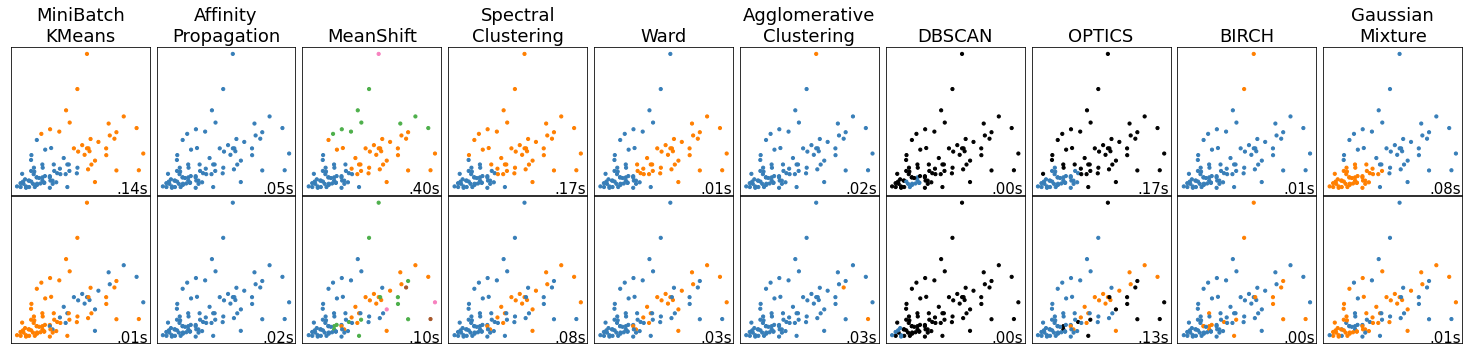

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
# n_samples = 1500
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
# noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
# blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
# random_state = 170
# X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(X, transformation)
# aniso = (X_aniso, y)

scaled = (X_reg, [])
raw = (X, [])

# blobs with varied variances
# varied = datasets.make_blobs(
#     n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
# )

# ============
# Set up cluster parameters
# ============
# plt.figure(figsize=(9 * 2 + 3, 13))
plt.figure(figsize=(9 * 2 + 3, 13/3))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 2,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        scaled,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 10,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        }
    ),
    (
        raw,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 10,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        }
    )
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    # print(X)
    # print(type(X))

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        # plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.scatter(X_reg[:, 0], X_reg[:, 1], s=10, color=colors[y_pred])

        # plt.xlim(-2.5, 2.5)
        # plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()